In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-05-14 12:15:47.843939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 12:15:48.400055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-05-14 12:15:48.400518: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=55,CROP1=CROP,BATCH_SIZE=50,N_REPEAT_FRAME1=10)

2023-05-14 12:15:49.198561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 12:15:49.198779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 12:15:49.204027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 12:15:49.204241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 12:15:49.204419: I tensorflow/compiler/xla/stream_executo

In [10]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

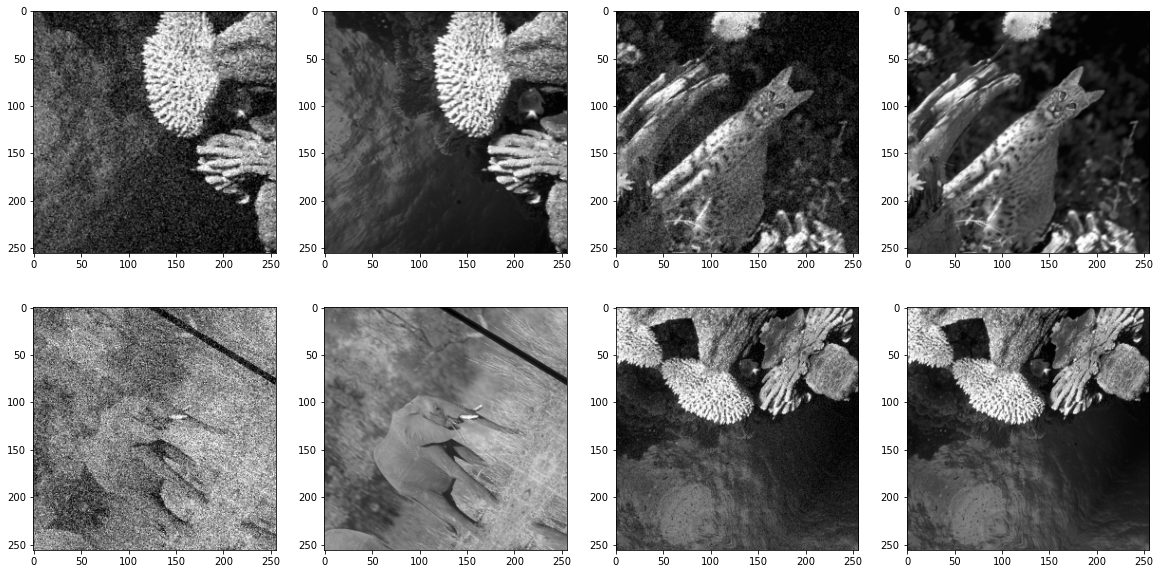

In [12]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

In [13]:
from open_frame import open_frame as OF
'/gpfs/soma_fs/home/ortega/thesis/images/Set12/09.png'

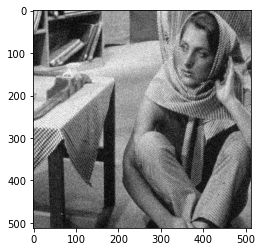

In [36]:
a,b = OF('gaussian',1)('../../images/Set12/09.png',var=20,CROP=512)
plt.imshow(b,cmap='gray')

In [51]:
set12_256 = ['../../images/Set12/02.png','../../images/Set12/03.png']
set12_512 = ['../../images/Set12/09.png','../../images/Set12/10.png']

variance = [1,2,5,10,15,20,25,50,75,100]

set12_256 = np.array([[OF('gaussian',v)(im,var=v,CROP=256) for v in variance] for im in set12_256])
ys_256,noisy_256 = set12_256[:,:,0],set12_256[:,:,1]
ys_256,noisy_256 = np.concatenate(ys_256),np.concatenate(noisy_256)
ys_256,noisy_256 = np.expand_dims(ys_256,axis=-1),np.expand_dims(noisy_256,axis=-1)

set12_512 = np.array([[OF('gaussian',v)(im,var=v,CROP=512) for v in variance] for im in set12_512])
ys_512,noisy_512 = set12_512[:,:,0],set12_512[:,:,1]
ys_512,noisy_512 = np.concatenate(ys_512),np.concatenate(noisy_512)
ys_512,noisy_512 = np.expand_dims(ys_512,axis=-1),np.expand_dims(noisy_512,axis=-1)


In [48]:
ys_256,noisy_256 = set12_256[:,:,0],set12_256[:,:,1]
ys_256,noisy_256 = np.concatenate(ys_256),np.concatenate(noisy_256)
ys_256,noisy_256 = np.expand_dims(ys_256,axis=-1),np.expand_dims(noisy_256,axis=-1)
noisy_256.shape

(20, 256, 256, 1)

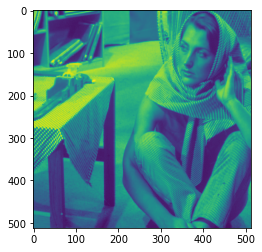

In [62]:
plt.imshow(ys_512[9])

# Training

In [2]:
class losses:
    def Linfty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
        return error

    def W1infty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dx_true-dx_pred))))
        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dy_true-dy_pred))))


        return error

    def H1(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.reduce_mean(tf.pow(dx_true-dx_pred,2))
        error += tf.math.reduce_mean(tf.pow(dy_true-dy_pred,2))
        error = tf.sqrt(error)

        return error

    def L2(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))  

        return error
    
    def probability(y_true,y_pred):
        error = -tf.image.ssim(y_true,y_pred,1)

        return error
    
    def psnr(y_true,y_pred):
        return -tf.image.psnr(y_true,y_pred,1)


losses_names = ['H1','L2']


In [8]:
architectures = ['splines','decreasing','flux']

for N_REPEAT_FRAME1 in [1,10,30]:

    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=55,CROP1=CROP,BATCH_SIZE=30,
                                                   N_REPEAT_FRAME1=N_REPEAT_FRAME1)

    for arch in architectures:
        print(arch)

        for loss in losses_names:
            print(loss)

            order = 1
            for num_classes in [5,20,50]:
                print('num_classes: ',num_classes)
                
                if len(glob(f'../{arch}/history/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_f.npy')) > 0:
                    print(glob(f'../{arch}/history/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_f.npy'))
                    continue



                model = get_model(arch,it_lim=10,image_size=image_size,num_classes = num_classes,
                                 second=False)
                model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                        loss=getattr(losses,loss))

                callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"../{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_f",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
                tf.keras.callbacks.TerminateOnNaN()

                ]

                history = model.fit(
                    gen_batch_train,
                    epochs=50,
                    steps_per_epoch=100,
                    validation_data=gen_batch_val,
                    validation_steps=10,
                    shuffle=False,
                    use_multiprocessing=True,
                    callbacks=callbacks,
                    workers=1
                )

                np.save(f'../{arch}/history/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_f.npy',np.array([history.history['loss'],history.history['val_loss']]))


splines
H1
num_classes:  5
['../splines/history/splinesH1_gaussian_5_1_f.npy']
num_classes:  20
['../splines/history/splinesH1_gaussian_20_1_f.npy']
num_classes:  50
['../splines/history/splinesH1_gaussian_50_1_f.npy']
L2
num_classes:  5
['../splines/history/splinesL2_gaussian_5_1_f.npy']
num_classes:  20
['../splines/history/splinesL2_gaussian_20_1_f.npy']
num_classes:  50
['../splines/history/splinesL2_gaussian_50_1_f.npy']
decreasing
H1
num_classes:  5
['../decreasing/history/decreasingH1_gaussian_5_1_f.npy']
num_classes:  20
['../decreasing/history/decreasingH1_gaussian_20_1_f.npy']
num_classes:  50
['../decreasing/history/decreasingH1_gaussian_50_1_f.npy']
L2
num_classes:  5
['../decreasing/history/decreasingL2_gaussian_5_1_f.npy']
num_classes:  20
['../decreasing/history/decreasingL2_gaussian_20_1_f.npy']
num_classes:  50
['../decreasing/history/decreasingL2_gaussian_50_1_f.npy']
flux
H1
num_classes:  5
['../flux/history/fluxH1_gaussian_5_1_f.npy']
num_classes:  20
['../flux/hist

100/100 [==============================] - ETA: 0s - loss: 0.0823
Epoch 8: val_loss did not improve from 0.08771
100/100 [==============================] - 27s 266ms/step - loss: 0.0823 - val_loss: 0.0894 - lr: 2.0000e-04
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 0.0844
Epoch 9: val_loss improved from 0.08771 to 0.08299, saving model to ../decreasing/checkpoints/decreasingH1_gaussian_20_10_f
100/100 [==============================] - 27s 267ms/step - loss: 0.0844 - val_loss: 0.0830 - lr: 2.0000e-04
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 0.0832
Epoch 10: val_loss improved from 0.08299 to 0.08046, saving model to ../decreasing/checkpoints/decreasingH1_gaussian_20_10_f
100/100 [==============================] - 27s 268ms/step - loss: 0.0832 - val_loss: 0.0805 - lr: 2.0000e-04
Epoch 11/50
100/100 [==============================] - ETA: 0s - loss: 0.0838
Epoch 11: val_loss did not improve from 0.08046
100/100 [=====================

Epoch 40/50
100/100 [==============================] - ETA: 0s - loss: 0.0816
Epoch 40: val_loss did not improve from 0.07434
100/100 [==============================] - 26s 265ms/step - loss: 0.0816 - val_loss: 0.0814 - lr: 1.6000e-06
Epoch 41/50
100/100 [==============================] - ETA: 0s - loss: 0.0827
Epoch 41: val_loss did not improve from 0.07434
100/100 [==============================] - 27s 265ms/step - loss: 0.0827 - val_loss: 0.0797 - lr: 1.6000e-06
Epoch 42/50
100/100 [==============================] - ETA: 0s - loss: 0.0821
Epoch 42: val_loss did not improve from 0.07434
100/100 [==============================] - 26s 265ms/step - loss: 0.0821 - val_loss: 0.0748 - lr: 1.6000e-06
Epoch 43/50
100/100 [==============================] - ETA: 0s - loss: 0.0808
Epoch 43: val_loss did not improve from 0.07434

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
100/100 [==============================] - 27s 265ms/step - loss: 0.0808 - val_loss: 0.0796

100/100 [==============================] - 56s 557ms/step - loss: 40.1988 - val_loss: 48.8862 - lr: 8.0000e-06
Epoch 23/50
100/100 [==============================] - ETA: 0s - loss: 43.2300
Epoch 23: val_loss did not improve from 0.10380
100/100 [==============================] - 56s 557ms/step - loss: 43.2300 - val_loss: 37.2352 - lr: 8.0000e-06
Epoch 24/50
100/100 [==============================] - ETA: 0s - loss: 40.6372
Epoch 24: val_loss did not improve from 0.10380
100/100 [==============================] - 56s 557ms/step - loss: 40.6372 - val_loss: 37.0135 - lr: 8.0000e-06
Epoch 25/50
100/100 [==============================] - ETA: 0s - loss: 40.9630
Epoch 25: val_loss did not improve from 0.10380
100/100 [==============================] - 56s 557ms/step - loss: 40.9630 - val_loss: 47.4522 - lr: 8.0000e-06
Epoch 26/50
100/100 [==============================] - ETA: 0s - loss: 40.1966
Epoch 26: val_loss did not improve from 0.10380

Epoch 26: ReduceLROnPlateau reducing learning r

100/100 [==============================] - 22s 219ms/step - loss: 0.0038 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.0034
Epoch 5: val_loss did not improve from 0.00314
100/100 [==============================] - 21s 213ms/step - loss: 0.0034 - val_loss: 0.0041 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 0.0035
Epoch 6: val_loss did not improve from 0.00314
100/100 [==============================] - 21s 216ms/step - loss: 0.0035 - val_loss: 0.0042 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - ETA: 0s - loss: 0.0034
Epoch 7: val_loss did not improve from 0.00314
100/100 [==============================] - 22s 217ms/step - loss: 0.0034 - val_loss: 0.0040 - lr: 0.0010
Epoch 8/50
100/100 [==============================] - ETA: 0s - loss: 0.0031
Epoch 8: val_loss improved from 0.00314 to 0.00311, saving model to ../decreasing/checkpoints/decreasingL2_gaussian_5_10_f
100/100 

Epoch 18/50
100/100 [==============================] - ETA: 0s - loss: 0.0029
Epoch 18: val_loss did not improve from 0.00257
100/100 [==============================] - 26s 265ms/step - loss: 0.0029 - val_loss: 0.0030 - lr: 2.0000e-04
Epoch 19/50
100/100 [==============================] - ETA: 0s - loss: 0.0030
Epoch 19: val_loss did not improve from 0.00257
100/100 [==============================] - 26s 264ms/step - loss: 0.0030 - val_loss: 0.0030 - lr: 2.0000e-04
Epoch 20/50
100/100 [==============================] - ETA: 0s - loss: 0.0030
Epoch 20: val_loss did not improve from 0.00257

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
100/100 [==============================] - 26s 265ms/step - loss: 0.0030 - val_loss: 0.0036 - lr: 2.0000e-04
Epoch 21/50
100/100 [==============================] - ETA: 0s - loss: 0.0028
Epoch 21: val_loss did not improve from 0.00257
100/100 [==============================] - 26s 265ms/step - loss: 0.0028 - val_loss: 0.003

Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 0.0029
Epoch 32: val_loss did not improve from 0.00274
100/100 [==============================] - 56s 556ms/step - loss: 0.0029 - val_loss: 0.0030 - lr: 1.6000e-06
Epoch 33/50
100/100 [==============================] - ETA: 0s - loss: 0.0031
Epoch 33: val_loss did not improve from 0.00274
100/100 [==============================] - 56s 556ms/step - loss: 0.0031 - val_loss: 0.0031 - lr: 1.6000e-06
Epoch 34/50
100/100 [==============================] - ETA: 0s - loss: 0.0032
Epoch 34: val_loss did not improve from 0.00274

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
100/100 [==============================] - 56s 556ms/step - loss: 0.0032 - val_loss: 0.0031 - lr: 1.6000e-06
Epoch 35/50
100/100 [==============================] - ETA: 0s - loss: 0.0030
Epoch 35: val_loss did not improve from 0.00274
100/100 [==============================] - 56s 556ms/step - loss: 0.0030 - val_loss: 0.0029

100/100 [==============================] - 21s 214ms/step - loss: 0.5604 - val_loss: 0.4659 - lr: 4.0000e-05
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 0.5494
Epoch 15: val_loss did not improve from 0.09179
100/100 [==============================] - 21s 215ms/step - loss: 0.5494 - val_loss: 0.5926 - lr: 4.0000e-05
Epoch 16/50
100/100 [==============================] - ETA: 0s - loss: 0.5563
Epoch 16: val_loss did not improve from 0.09179

Epoch 16: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
100/100 [==============================] - 21s 214ms/step - loss: 0.5563 - val_loss: 0.5629 - lr: 4.0000e-05
Epoch 17/50
100/100 [==============================] - ETA: 0s - loss: 0.5445
Epoch 17: val_loss did not improve from 0.09179
100/100 [==============================] - 21s 215ms/step - loss: 0.5445 - val_loss: 0.4903 - lr: 8.0000e-06
Epoch 18/50
100/100 [==============================] - ETA: 0s - loss: 0.5411
Epoch 18: val_loss did not imp

Epoch 30/50
100/100 [==============================] - ETA: 0s - loss: 12.2438
Epoch 30: val_loss did not improve from 1.42297
100/100 [==============================] - 46s 455ms/step - loss: 12.2438 - val_loss: 16.4649 - lr: 3.2000e-07
Epoch 31/50
100/100 [==============================] - ETA: 0s - loss: 12.7511
Epoch 31: val_loss did not improve from 1.42297

Epoch 31: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
100/100 [==============================] - 46s 456ms/step - loss: 12.7511 - val_loss: 14.4370 - lr: 3.2000e-07
Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 11.9855
Epoch 32: val_loss did not improve from 1.42297
100/100 [==============================] - 46s 456ms/step - loss: 11.9855 - val_loss: 12.4525 - lr: 6.4000e-08
Epoch 33/50
100/100 [==============================] - ETA: 0s - loss: 12.5454
Epoch 33: val_loss did not improve from 1.42297
100/100 [==============================] - 46s 456ms/step - loss: 12.5454 - val_l

100/100 [==============================] - 108s 1s/step - loss: 10.9051 - val_loss: 10.7673 - lr: 4.0000e-05
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 10.3658
Epoch 13: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 10.3658 - val_loss: 9.9617 - lr: 4.0000e-05
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 10.2382
Epoch 14: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 10.2382 - val_loss: 9.7932 - lr: 4.0000e-05
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 9.9404
Epoch 15: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 9.9404 - val_loss: 9.5682 - lr: 4.0000e-05
Epoch 16/50
100/100 [==============================] - ETA: 0s - loss: 9.5590
Epoch 16: val_loss did not improve from 0.10325

Epoch 16: ReduceLROnPlateau reducing learning rate to 8.00000

Epoch 46/50
100/100 [==============================] - ETA: 0s - loss: 9.1204
Epoch 46: val_loss did not improve from 0.10325

Epoch 46: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.
100/100 [==============================] - 108s 1s/step - loss: 9.1204 - val_loss: 10.8710 - lr: 2.5600e-09
Epoch 47/50
100/100 [==============================] - ETA: 0s - loss: 9.1550
Epoch 47: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 9.1550 - val_loss: 9.9575 - lr: 5.1200e-10
Epoch 48/50
100/100 [==============================] - ETA: 0s - loss: 9.2142
Epoch 48: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 9.2142 - val_loss: 8.7850 - lr: 5.1200e-10
Epoch 49/50
100/100 [==============================] - ETA: 0s - loss: 9.0405
Epoch 49: val_loss did not improve from 0.10325
100/100 [==============================] - 108s 1s/step - loss: 9.0405 - val_loss: 8.9072 - lr: 5.

Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.0096
Epoch 29: val_loss did not improve from 0.00359
100/100 [==============================] - 21s 214ms/step - loss: 0.0096 - val_loss: 0.0193 - lr: 3.2000e-07
Epoch 30/50
100/100 [==============================] - ETA: 0s - loss: 0.0094
Epoch 30: val_loss did not improve from 0.00359
100/100 [==============================] - 21s 210ms/step - loss: 0.0094 - val_loss: 0.1566 - lr: 3.2000e-07
Epoch 31/50
100/100 [==============================] - ETA: 0s - loss: 0.0094
Epoch 31: val_loss did not improve from 0.00359

Epoch 31: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
100/100 [==============================] - 21s 212ms/step - loss: 0.0094 - val_loss: 0.2141 - lr: 3.2000e-07
Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 0.0093
Epoch 32: val_loss did not improve from 0.00359
100/100 [==============================] - 21s 211ms/step - loss: 0.0093 - val_loss: 0.0098

100/100 [==============================] - 45s 454ms/step - loss: 362.2075 - val_loss: 326.0594 - lr: 2.0000e-04
Epoch 12/50
100/100 [==============================] - ETA: 0s - loss: 314.6085
Epoch 12: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 453ms/step - loss: 314.6085 - val_loss: 374.8745 - lr: 4.0000e-05
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 364.7928
Epoch 13: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 453ms/step - loss: 364.7928 - val_loss: 127.2073 - lr: 4.0000e-05
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 340.8687
Epoch 14: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 454ms/step - loss: 340.8687 - val_loss: 68.1972 - lr: 4.0000e-05
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 305.9966
Epoch 15: val_loss did not improve from 0.00421
100/100 [============================

Epoch 44/50
100/100 [==============================] - ETA: 0s - loss: 333.5847
Epoch 44: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 453ms/step - loss: 333.5847 - val_loss: 171.4448 - lr: 2.5600e-09
Epoch 45/50
100/100 [==============================] - ETA: 0s - loss: 330.6203
Epoch 45: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 454ms/step - loss: 330.6203 - val_loss: 284.6969 - lr: 2.5600e-09
Epoch 46/50
100/100 [==============================] - ETA: 0s - loss: 324.9666
Epoch 46: val_loss did not improve from 0.00421

Epoch 46: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.
100/100 [==============================] - 45s 453ms/step - loss: 324.9666 - val_loss: 467.7395 - lr: 2.5600e-09
Epoch 47/50
100/100 [==============================] - ETA: 0s - loss: 265.4717
Epoch 47: val_loss did not improve from 0.00421
100/100 [==============================] - 45s 454ms/step - loss: 265.471

KeyboardInterrupt: 

In [ ]:
architectures = ['splines','decreasing','flux']

for N_REPEAT_FRAME1 in [1,10,30]:

    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=55,CROP1=CROP,BATCH_SIZE=30,
                                                   N_REPEAT_FRAME1=N_REPEAT_FRAME1)

    for arch in architectures:
        print(arch)

        for loss in losses_names:
            print(loss)

            order = 1
            for num_classes in [5,20,50]:
                print('num_classes: ',num_classes)
                
                for degree in np.arange(3,17):
                    print(degree)



                    model = get_model(arch,it_lim=10,image_size=image_size,num_classes = num_classes,
                                     second=True,degree=degree)
                    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                            loss=getattr(losses,loss))

                    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                    filepath= f"../{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_t{degree}",
                    save_weights_only=True,
                    verbose = True,
                    save_best_only=True),
                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
                    tf.keras.callbacks.TerminateOnNaN()

                    ]

                    history = model.fit(
                        gen_batch_train,
                        epochs=50,
                        steps_per_epoch=100,
                        validation_data=gen_batch_val,
                        validation_steps=10,
                        shuffle=False,
                        use_multiprocessing=True,
                        callbacks=callbacks,
                        workers=1
                    )

                    np.save(f'../{arch}/history/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_t{degree}.npy',np.array([history.history['loss'],history.history['val_loss']]))
